In [6]:
from triqs.gf import *
from triqs.operators import *
from triqs.gf import Fourier
from h5 import *
import triqs.utility.mpi as mpi

from triqs.operators import *
from triqs_cthyb import Solver

from triqs.plot.mpl_interface import oplot,plt
from triqs.gf import MeshImTime
from triqs.gf import GfImFreq, GfImTime, make_gf_from_fourier

from triqs.gf import  MeshImTime, MeshReFreq, Gf
from triqs.plot.mpl_interface import oplot, plt

Starting serial run at: 2024-07-16 18:59:54.628389


In [7]:
from multiprocessing import Pool
from itertools import repeat
from functools import partial

%matplotlib inline
import csv
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# from pymatgen.electronic_structure.plotter import BSDOSPlotter, BSPlotter, DosPlotter
# from pymatgen.io.vasp.outputs import BSVasprun, Vasprun

import pickle 
from  tqdm import tqdm

In [8]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)


In [9]:
# import sys
# sys.path.append("./src")
# %load_ext autoreload
# %autoreload 2
# import DataBase
# import ml_model
# import Sample 

# One sample

In [12]:
def findExtrema(inputArray):
   arrayLength = len(inputArray)
   # storing the count of no of local extrema in an array
   outputCount = 0
   # traversing from the first index to the length of the given array
   for k in range(1, arrayLength - 1):
      # At any given time, only one of the following conditions will be true:
      # either a[i] will be greater than neighbors or less than neighbors.
      # check if a[i] if greater than both its neighbours
      # Here it increments the output count by 1 if the condition is true
      # Else it increments output count by 0(same value) if condition is False
      outputCount += (inputArray[k] > inputArray[k - 1] and inputArray[k] > inputArray[k + 1])
      # check if a[i] if lesser than both its neighbours
      outputCount += (inputArray[k] < inputArray[k - 1] and inputArray[k] < inputArray[k + 1])
   # returning the number of local extrema of the given array
   return outputCount

In [106]:
class sample():
    def __init__(self, 
                 beta=5.0, 
                 U=2.0, 
                 num_kpoints=21, 
                 n_iw=1025,
                 n_tau=2500, 
                 n_w=500,
                 e_window=4.0,
                 BS=None,
                 G0_iw=None,
                 G0w=None,
                 G0tau=None,
                 G0_legendre=None,
                 Gw=None,
                 Giw=None,
                 G_legendre=None,
                 Gtau=None,
                 Sigma_iw=None
                 ):

        self.beta = beta
        self.num_kpoints = num_kpoints
        self.n_iw = n_iw
        self.n_tau = n_tau
        self.n_w = n_w
        self.U = U
        self.e_window = e_window

        self.kpoints= np.linspace(-np.pi, np.pi, self.num_kpoints)
        self.niwmesh = np.linspace(-n_iw-1, n_iw, 2*n_iw)
        self.iwmesh = np.pi*(2*self.niwmesh+1)/self.beta
        self.taumesh = np.linspace(0, self.beta, self.n_tau)
        self.wmesh = np.linspace(-e_window, e_window, self.n_w)

        if G0_iw is not None:
            self.BS = BS
            self.G0_iw = G0_iw
            self.G0w = G0w
            self.G0tau = G0tau
            self.G0_legendre = G0_legendre
            self.Gw = Gw
            self.Giw = Giw
            self.G_legendre = G_legendre
            self.Gtau = Gtau
            self.Sigma_iw = Sigma_iw
        else:
            self.get_BS()
            self.get_Green()


        self.Gw = 0
        self.Giw = 0
        self.G_legendre = 0
        self.Gtau = 0
        self.Sigma_iw = 0
        
    @classmethod
    def fromdict(cls, datadict):
        "Initialize sample from a dict's items"
        return cls(**datadict)

    def save2dict(self):
        dict2save = {}
        dict2save['beta'] = self.beta 
        dict2save['U'] = self.U
        dict2save['num_kpoints'] = self.num_kpoints 
        dict2save['BS'] = self.BS 
        dict2save['n_iw'] = self.n_iw
        dict2save['n_tau'] = self.n_tau 
        dict2save['n_w'] = self.n_w
        dict2save['e_window'] = self.e_window
        dict2save['G0_iw'] = self.G0_iw
        dict2save['G0w'] = self.G0w
        dict2save['G0tau'] = self.G0tau
        dict2save['G0_legendre'] = self.G0_legendre
        dict2save['Gw'] = self.Gw
        dict2save['Giw'] = self.Giw
        dict2save['G_legendre'] = self.G_legendre
        dict2save['Gtau'] = self.Gtau
        dict2save['Sigma_iw'] = self.Sigma_iw
        return dict2save


    def get_BS(self):
        t1 = np.random.rand()*1.5
        t2 = np.random.rand()
        t3 = np.random.rand()
        kpts = self.kpoints
        BS = 2 * t1 * np.cos(kpts) + 2 * t2 * np.cos(2 * kpts) + 2 * t3 * np.cos(3 * kpts)
        # BS =
        # BS = -np.cos(self.kpoints) + (np.random.rand()*1.5)*(np.cos( self.kpoints)-1)*np.exp(-(np.pi-np.abs(self.kpoints)))+ np.random.rand() + \
        # (np.random.rand()*0.8)*(np.cos( 2*self.kpoints)-1)*np.exp(-(np.pi-np.abs(self.kpoints))) 
        self.BS = -BS - np.mean(-BS)



    def get_Green(self, saveQ=False):
        ''' 
        important

        self.G0_iw
        self.G0w
        self.G0tau
        self.G0_legendre
        '''
        # print(self.num_kpoints)
        iw_mesh = MeshImFreq(beta=self.beta, S='Fermion', n_iw=self.n_iw)
        self.Gks = [Gf(mesh=iw_mesh, target_shape=[1, 1]) for kpt in range(len(self.kpoints))]
        for kpt_ind, kpt in enumerate(range(len(self.kpoints)) ):
            self.Gks[kpt] << inverse(iOmega_n - self.BS[kpt_ind] - 0)
        self.Gks = np.array(self.Gks)

        dSarea = 1.0/(self.num_kpoints)
        # print(self.Gks.shape)
        
        ### G0(iw_n)
        self.G0_iw =  dSarea*np.sum( self.Gks, axis=0 )  
        # print(self.G0_iw)

        ### G0(w)
        w_mesh = MeshReFreq(window=(-4,4), n_w=self.n_w)
        self.G0w = Gf(mesh=w_mesh, target_shape=[1,1])
        #TODO n_points is a parameter that should be chosen that way to fullfill intergal dos is close to 1 and is nonnegative 
        
        arr = np.imag(self.G0_iw.data.flatten())
        n_points = findExtrema(arr)*3
        self.G0w.set_from_pade(self.G0_iw, n_points = n_points, freq_offset = 0.005)

        ### G0(tau)
        tau_mesh = MeshImTime(beta=self.beta, statistic='Fermion', n_tau=self.n_tau)
        #Mesh-points are evenly distributed in the interval [0,beta] including points at both edges.
        self.G0tau = Gf(mesh=tau_mesh, target_shape=[1,1])
        self.G0tau << Fourier(self.G0_iw)

        ### G0(legendre)
        self.G0_legendre = GfLegendre(indices = [1], beta = self.beta, n_points = 40)
        self.G0_legendre << MatsubaraToLegendre(self.G0_iw)

        if saveQ:
            with HDFArchive("features"+str(1) +".h5") as ar:
                ar["G0_tau-%s"%1] = self.G0tau
                ar["G0_iw-%s"%1] = self.G0_iw
                ar["G0_w-%s"%1] = self.G0w
                ar["G0_l-%s"%1] = self.G0_legendre
            

    def solve_impurity(self, n_cycles=5000,
                             length_cycle=200,
                             n_warmup_cycles=10000, saveQ=False):
        ''' 
        important
        
        self.Gw
        self.Giw
        self.G_legendre
        self.Gtau
        self.Sigma_iw
        
        '''
        

        # S = Solver(beta = self.beta, gf_struct = [ ('up',1), ('down',1) ])

        # # Initalize the Green's function to a Nonint DOS
        # for name , g0 in S.G_iw : g0 << self.G0_iw

        # # Run the solver
        # U = 5.0
        # S.solve(h_int = U * n('up',0) * n('down',0),    # Local Hamiltonian
        #         n_cycles = 5000,                        # Number of QMC cycles
        #         length_cycle = 200,                     # Length of a cycle
        #         n_warmup_cycles = 1000)                 # How many warmup cycles

        # U = 5.0
        # Create a solver instance
        gf_struct = [ ('up', 1), ('down', 1) ]
        S = Solver(beta = self.beta, gf_struct = gf_struct)
        h_int = self.U * n('up',0) * n('down',0)

        for name, g0 in S.G0_iw:
            g0 << self.G0_iw

        S.solve(h_int = h_int,
                n_cycles  = n_cycles,
                length_cycle = length_cycle,
                n_warmup_cycles = n_warmup_cycles,
                measure_G_l=True)

        g = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
        
        #TODO energy window should be chosen wisely 
        w_mesh = MeshReFreq(window=(-4,4), n_w=self.n_w)
        self.Gw = Gf(mesh=w_mesh, target_shape=[1,1])
        
        #TODO n_points is a parameter that should be chosen that way to fullfill intergal dos is close to 1 and is nonnegative 
        self.Gw.set_from_pade(g, n_points = 5, freq_offset = 0.005)
        self.Giw = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
        self.G_legendre = 0.5 * (S.G_l['up'] + S.G_l['down'])
        self.Gtau = 0.5 * (S.G_tau['up'] + S.G_tau['down'])
        self.Sigma_iw = 0.5 * (S.Sigma_iw['up'] + S.Sigma_iw['down'])

        if saveQ:
            with HDFArchive("targets"+str(1) +".h5") as ar:
                ar["G_tau-%s"%1] = 0.5 * (S.G_tau['up'] + S.G_tau['down'])
                ar["G_iw-%s"%1] = 0.5 * (S.G_iw['up'] + S.G_iw['down'])
                ar["G_l-%s"%1] =  0.5 * (S.G_l['up'] + S.G_l['down'])
                ar["Sigma_iw-%s"%1] = 0.5 * (S.Sigma_iw['up'] + S.Sigma_iw['down'])


    # def plot_G(self, which='iw'):
        
    #         fig, dd = plt.subplots(figsize=(6,3))
    #         # print(np.real(self.G0_iw))
    #         dd.plot(self.wmesh, np.real(self.Gw.data.flatten()), label='re')
    #         dd.plot(self.wmesh, np.imag(self.Gw.data.flatten()), label='im')
    #         # width = 10
    #         # fig.set_figwidth(width)     #  ширина и
    #         # fig.set_figheight(width/1.6)    #  высота "Figure"
    #         fig.set_label('Gw')
    #         plt.legend()
    #         # plt.xlim(-10, 10)

    #         plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.

    #         # plt.xlabel("X Label", fontsize=10)
    #         # plt.ylabel("Y Label", fontsize=10)
    #         # plt.colorbar()
    #         # plt.savefig('./Green_up.png', dpi=200, bbox_inches='tight')

    #         plt.show()
        


    def plotBS(self):
        fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
        normal_ticks = [-np.pi, 0, np.pi]
        label_ticks = [r'-$\pi$', 'G', r'$\pi$']
        ax1.plot(self.kpoints, self.BS, label="BS")

        ax1.set_title("Sample's 1D band structure")
        ax1.set_xlabel("k")
        ax1.set_ylabel(r'E - $E_f$ [Ev]')
        plt.xticks(normal_ticks, label_ticks)
        ax1.yaxis.set_minor_locator(MultipleLocator(1))
        plt.grid(axis='x')
        ax1.axhline(y=0, ls='--', color='k')
        plt.xlim(normal_ticks[0], normal_ticks[-1])
        
        plt.tight_layout()
        plt.show()


    def plot_G0(self, which='iw'):
        if which == 'iw':
            fig, dd = plt.subplots(figsize=(5,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.niwmesh, np.real(self.G0_iw.data.flatten()), label='Re G')
            dd.plot(self.niwmesh, np.imag(self.G0_iw.data.flatten()), label='Im G')
            dd.legend(prop={'size': 8}, loc='upper right', frameon=False)  # Add a legend.
            dd.set_title(r'$G_0(i \omega)$')
            plt.xlim(-100, 100)
            # plt.ylabel(r'G [1/Ev]')  # Add an x-label to the axes
            plt.show()

        elif which == 'w':
            fig, dd = plt.subplots(figsize=(5,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.wmesh, np.real(self.G0w.data.flatten()), label='Re G')
            dd.plot(self.wmesh, np.imag(self.G0w.data.flatten()), label='Im G')
            dd.legend(prop={'size': 8}, loc='upper right', frameon=False)  # Add a legend.
            dd.set_title(r'$G_0(\omega)$')
            plt.xlim(-3, 3)
            plt.legend()
            
            # plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.
            plt.show()

            
        elif which == 'tau':
            fig, dd = plt.subplots(figsize=(5,3))
            normal_ticks = [ 0, self.beta]
            label_ticks = ['0', r'$\beta$']
            dd.plot(self.taumesh, np.real(self.G0tau.data.flatten()))
            dd.set_title(r'$G_0(\tau)$')
            plt.xticks(normal_ticks, label_ticks)
            dd.yaxis.set_minor_locator(MultipleLocator(1))
            # plt.grid(axis='x')
            # dd.axhline(y=0, ls='--', color='k')
            plt.xlim(normal_ticks[0], normal_ticks[-1])
            plt.ylim(-0.7, 0)
            plt.show()

        elif which == 'legendre':
            fig, dd = plt.subplots(figsize=(3,2))
            dd.scatter(np.arange(0, 40, 1), np.real(self.G0_legendre.data.flatten()), label='re')
            fig.set_label('G0leg')
            plt.ylabel(r'l')  # Add an x-label to the axes.
            plt.show()


    def plot_G(self, which='iw'):
        if which == 'iw':
            fig, dd = plt.subplots(figsize=(5,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.niwmesh, np.real(self.Giw.data.flatten()), color='g', label='Re G')
            dd.plot(self.niwmesh, np.imag(self.Giw.data.flatten()), color='r', label='Im G')
            dd.legend(prop={'size': 8}, loc='upper right', frameon=False)  # Add a legend.
            dd.set_title(r'$G(i \omega)$')
            plt.xlim(-100, 100)
            plt.ylabel(r'G [1/Ev]')  # Add an x-label to the axes
            plt.show()

        elif which == 'w':
            fig, dd = plt.subplots(figsize=(5,3))
            # print(np.real(self.G0_iw))
            dd.plot(self.wmesh, np.real(self.Gw.data.flatten()), label='Re G')
            dd.plot(self.wmesh, np.imag(self.Gw.data.flatten()), label='Im G')
            dd.legend(prop={'size': 8}, loc='upper right', frameon=False)  # Add a legend.
            dd.set_title(r'$G(\omega)$')
            plt.xlim(-3, 3)
            plt.legend()
            
            # plt.ylabel(r'E - $E_f$ [Ev]')  # Add an x-label to the axes.
            plt.show()

            
        elif which == 'tau':
            fig, dd = plt.subplots(figsize=(5,3))
            normal_ticks = [ 0, self.beta]
            label_ticks = ['0', r'$\beta$']

            G_rebinned = self.Gtau.rebinning_tau(new_n_tau=self.n_tau)
            dd.plot(self.taumesh, np.real(G_rebinned.data.flatten()))
            dd.set_title(r'$G(\tau)$')
            plt.xticks(normal_ticks, label_ticks)
            dd.yaxis.set_minor_locator(MultipleLocator(1))
            # plt.grid(axis='x')
            # dd.axhline(y=0, ls='--', color='k')
            plt.xlim(normal_ticks[0], normal_ticks[-1])
            plt.ylim(-0.7, 0)
            plt.show()

        elif which == 'legendre':
            fig, dd = plt.subplots(figsize=(3,2))
            dd.scatter(np.arange(0, 30, 1), np.real(self.G_legendre.data.flatten()), label='re')
            fig.set_label('G legendre')
            plt.ylabel(r'l')  # Add an x-label to the axes.
            plt.show()

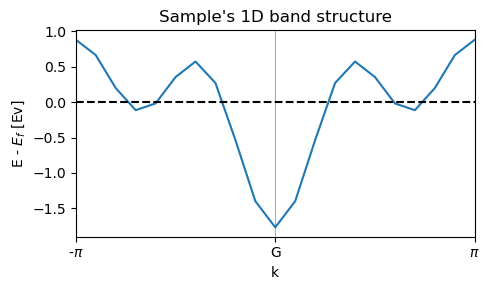

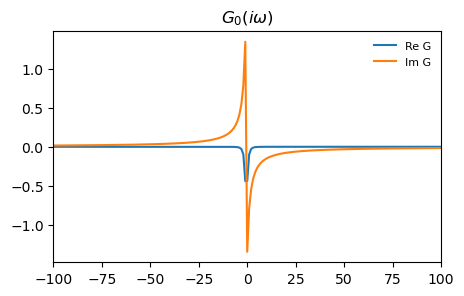

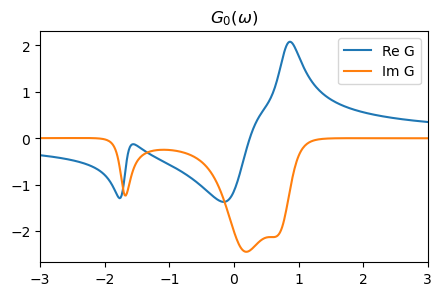

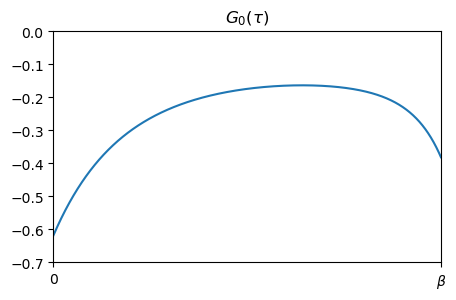

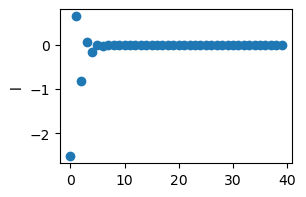

In [110]:
sample1 = sample(beta=10.0)
sample1.plotBS()
sample1.plot_G0('iw')
sample1.plot_G0('w')
sample1.plot_G0('tau')
sample1.plot_G0('legendre')

In [111]:
sample1.solve_impurity()


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
20:31:46   3% ETA 00:00:02 cycle 347 of 10000
20:31:48  78% ETA 00:00:00 cycle 7829 of 10000
20:31:49 100% ETA 00:00:00 cycle 9999 of 10000



Accumulating ...
20:31:49   7% ETA 00:00:01 cycle 361 of 5000
20:31:50 100% ETA 00:00:00 cycle 4999 of 5000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00786715
Average order         | 0.00617856
Average sign          | 0.00612809
G_l measure           | 0.0204696 
G_tau measure         | 0.00894553
Total measure time    | 0.0495889 
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.174715
  Move  Insert 

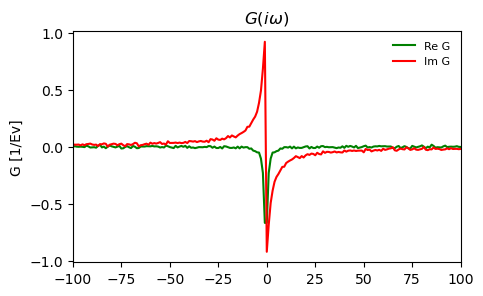

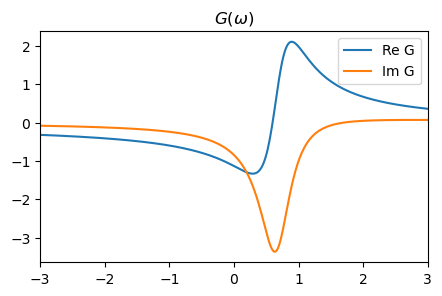

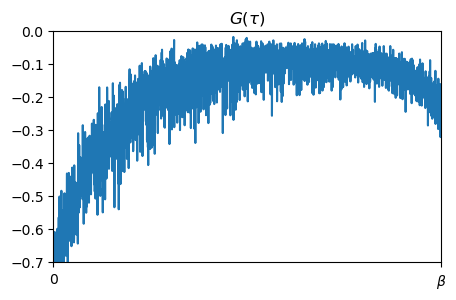

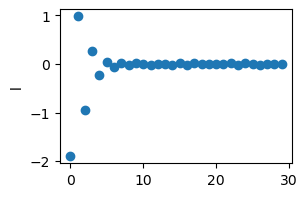

In [112]:
sample1.plot_G('iw')
sample1.plot_G('w')
sample1.plot_G('tau')
sample1.plot_G('legendre')